# Module 4 - Lesson 1: Feature Engineering Fundamentals

## Building Predictive Power Through Feature Creation

Welcome! This notebook will help you practice feature engineering - the art and science of creating new variables from your existing data to improve machine learning models. Feature engineering is often the difference between a mediocre model and a great one.

### What You'll Learn:
- How to transform variables mathematically to make them more useful
- Creating meaningful ratios and combinations from existing features
- Building binary flags that capture important conditions
- Converting continuous data into categories (binning)
- Extracting valuable information from dates and times
- Creating interaction features that capture relationships
- Working with text data to extract numeric features

## Setup: Import Required Libraries

First, let's import all the libraries we'll need for this lesson. Don't worry if you don't recognize all of them yet - we'll explain each one as we use it.

In [2]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# For text processing
import re
from textblob import TextBlob

# Machine learning libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualization (optional, for exploring features)
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Mathematical Transformations

### Why Mathematical Transformations?

Many real-world variables have skewed distributions (like income, where most people earn moderate amounts but a few earn extremely high amounts). Machine learning algorithms often work better with normally distributed data. Mathematical transformations can help:
- **Normalize skewed distributions** making them more bell-curve shaped
- **Reduce the impact of outliers** by compressing large values
- **Capture non-linear relationships** that simple linear models might miss

Let's start by creating some sample data that mimics real-world distributions:

In [3]:
# Create sample data
np.random.seed(42)
df = pd.DataFrame({
    'income': np.random.lognormal(10, 2, 1000),  # Lognormal simulates income distribution
    'age': np.random.uniform(18, 80, 1000),      # Uniform distribution for age
    'transaction_amount': np.random.exponential(100, 1000)  # Exponential for transaction amounts
})

print("Original data shape:", df.shape)
print("\nFirst few rows:")
df.head()

Original data shape: (1000, 3)

First few rows:


,income,age,transaction_amount
0,59481.957248,28.383920,24.726824
1,16705.134357,24.483206,3.741257
2,80448.867576,57.458675,11.431802
3,463267.404013,61.801495,41.379064
4,13789.921118,19.958341,162.245061


### Applying Transformations

Now let's apply several common transformations. Each has its purpose:
- **Log transformation**: Best for highly skewed data (reduces extreme values)
- **Square root**: For moderately skewed data (gentler than log)
- **Square/Power**: Can capture polynomial relationships

In [4]:
# Log transformations for skewed distributions
df['log_income'] = np.log1p(df['income'])  # log1p = log(1+x), handles zeros safely
df['log_amount'] = np.log1p(df['transaction_amount'])

# Square root for moderate skew
df['sqrt_amount'] = np.sqrt(df['transaction_amount'])

# Power transformations
df['income_squared'] = df['income'] ** 2
df['age_squared'] = df['age'] ** 2

print("After mathematical transformations:")
print(df[['income', 'log_income', 'transaction_amount', 'sqrt_amount']].head())

After mathematical transformations:
          income  log_income  transaction_amount  sqrt_amount
0   59481.957248   10.993445           24.726824     4.972607
1   16705.134357    9.723531            3.741257     1.934233
2   80448.867576   11.295390           11.431802     3.381095
3  463267.404013   13.046062           41.379064     6.432656
4   13789.921118    9.531766          162.245061    12.737545


### Visualizing the Impact

Let's see how log transformation actually changes the distribution. Notice how the highly skewed income distribution becomes more normal (bell-shaped) after transformation:

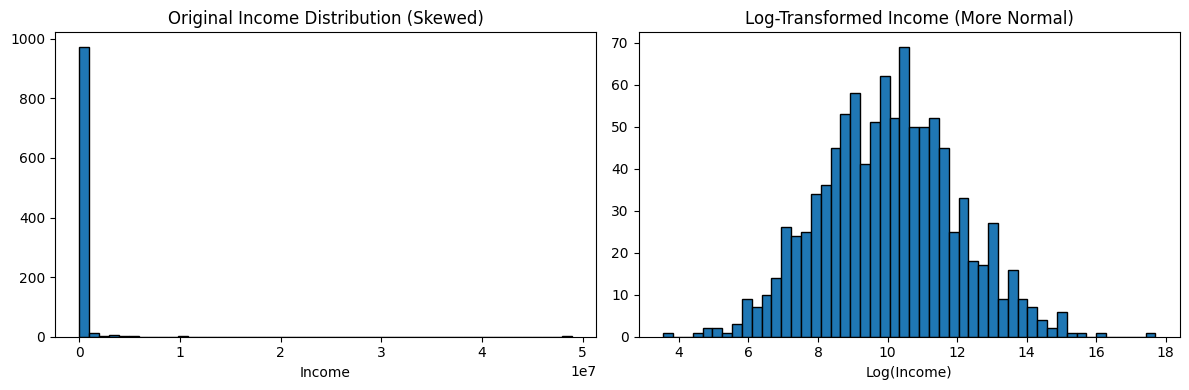

In [5]:
# Visualize the effect of log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original distribution
axes[0].hist(df['income'], bins=50, edgecolor='black')
axes[0].set_title('Original Income Distribution (Skewed)')
axes[0].set_xlabel('Income')

# Log-transformed distribution
axes[1].hist(df['log_income'], bins=50, edgecolor='black')
axes[1].set_title('Log-Transformed Income (More Normal)')
axes[1].set_xlabel('Log(Income)')

plt.tight_layout()
plt.show()

**Key Insight**: The log transformation has made the income distribution much more symmetric. This can significantly improve model performance, especially for linear models and neural networks.

## 2. Creating Ratios and Combinations

### The Power of Ratios

Individual features tell part of the story, but ratios often reveal deeper insights. For example:
- **Pages per minute** is more meaningful than just page views
- **Debt-to-income ratio** is what lenders actually care about, not just debt
- **Conversion rate** matters more than raw purchase counts

Let's create an e-commerce dataset to demonstrate:

In [6]:
# Create sample e-commerce data
df_ecommerce = pd.DataFrame({
    'page_views': np.random.poisson(20, 500),
    'time_on_site': np.random.exponential(300, 500),  # seconds
    'items_viewed': np.random.poisson(5, 500),
    'cart_additions': np.random.poisson(2, 500),
    'purchases': np.random.binomial(3, 0.3, 500),
    'revenue': np.random.exponential(50, 500),
    'length': np.random.uniform(10, 100, 500),
    'width': np.random.uniform(5, 50, 500),
    'height': np.random.uniform(2, 20, 500),
    'debt': np.random.exponential(5000, 500),
    'income': np.random.lognormal(10, 1, 500),
    'visits': np.random.poisson(10, 500),
    'output': np.random.uniform(100, 1000, 500),
    'input': np.random.uniform(50, 500, 500)
})

print("E-commerce data created:", df_ecommerce.shape)

E-commerce data created: (500, 14)


### Engineering Meaningful Ratios

Now let's create ratios that actually mean something for business decisions. Notice how we always add 1 to denominators to avoid division by zero errors:

In [7]:
# Engagement ratios - How engaged are users?
df_ecommerce['pages_per_minute'] = df_ecommerce['page_views'] / (df_ecommerce['time_on_site'] / 60)
df_ecommerce['view_to_cart_ratio'] = df_ecommerce['cart_additions'] / (df_ecommerce['items_viewed'] + 1)  
df_ecommerce['cart_conversion'] = df_ecommerce['purchases'] / (df_ecommerce['cart_additions'] + 1)

# Financial health ratios - Can customers afford to buy?
df_ecommerce['debt_to_income'] = df_ecommerce['debt'] / df_ecommerce['income']
df_ecommerce['revenue_per_purchase'] = df_ecommerce['revenue'] / (df_ecommerce['purchases'] + 1)

# Physical dimensions - Useful for shipping/storage
df_ecommerce['volume'] = df_ecommerce['length'] * df_ecommerce['width'] * df_ecommerce['height']
df_ecommerce['surface_area'] = 2 * (df_ecommerce['length'] * df_ecommerce['width'] + 
                                     df_ecommerce['length'] * df_ecommerce['height'] + 
                                     df_ecommerce['width'] * df_ecommerce['height'])

# Efficiency metrics - How well does the business operate?
df_ecommerce['conversion_rate'] = df_ecommerce['purchases'] / (df_ecommerce['visits'] + 1)
df_ecommerce['efficiency'] = df_ecommerce['output'] / df_ecommerce['input']

print("Created ratio features:")
print(df_ecommerce[['pages_per_minute', 'view_to_cart_ratio', 'debt_to_income', 'efficiency']].head())

Created ratio features:
   pages_per_minute  view_to_cart_ratio  debt_to_income  efficiency
0         45.893315            0.400000        0.523433    3.518470
1          3.663565            0.100000        0.396575    1.493319
2          5.252036            1.333333        0.274327    2.338908
3          6.116471            0.333333        0.023832    2.607153
4          4.885714            0.363636        0.134611   14.275197


**Key Insight**: These ratios are often more predictive than the raw values. A model trying to predict customer lifetime value would likely find 'conversion_rate' more useful than separate 'purchases' and 'visits' features.

## 3. Creating Indicator Variables (Binary Flags)

### Why Binary Flags Matter

Binary flags (0 or 1 values) capture important yes/no conditions in your data. They're powerful because:
- They clearly separate groups (weekend vs. weekday)
- They capture threshold effects (is this customer high-value?)
- They can encode domain knowledge (is this risky behavior?)

First, let's add some more data to work with:

In [8]:
# Add some categorical and temporal data to our DataFrame
df_ecommerce['day_of_week'] = np.random.randint(0, 7, 500)  # 0=Monday, 6=Sunday
df_ecommerce['hour'] = np.random.randint(0, 24, 500)        # Hour of day
df_ecommerce['last_login_days'] = np.random.exponential(10, 500)  # Days since last login
df_ecommerce['satisfaction'] = np.random.uniform(1, 5, 500)       # 1-5 rating
df_ecommerce['total_spent'] = np.random.exponential(500, 500)     # Total historical spend
df_ecommerce['account_age_days'] = np.random.uniform(1, 1000, 500)  # How long they've been a customer
df_ecommerce['email'] = np.random.choice([None, 'user@email.com'], 500, p=[0.1, 0.9])
df_ecommerce['phone'] = np.random.choice([None, '555-1234'], 500, p=[0.15, 0.85])
df_ecommerce['discount'] = np.random.choice([0, 5, 10, 15, 20], 500, p=[0.5, 0.2, 0.15, 0.1, 0.05])
df_ecommerce['price'] = np.random.exponential(75, 500)

### Creating Meaningful Flags

Now let's create flags that capture important business conditions. Each flag answers a specific question about the customer or transaction:

In [9]:
# Time-based flags - When are customers shopping?
df_ecommerce['is_weekend'] = df_ecommerce['day_of_week'].isin([5, 6]).astype(int)
df_ecommerce['is_business_hours'] = df_ecommerce['hour'].between(9, 17).astype(int)

# Value-based flags - Is this a valuable transaction/customer?
df_ecommerce['high_value'] = (df_ecommerce['price'] > df_ecommerce['price'].quantile(0.9)).astype(int)
df_ecommerce['has_discount'] = (df_ecommerce['discount'] > 0).astype(int)
df_ecommerce['is_premium'] = (df_ecommerce['price'] > 100).astype(int)

# Activity-based flags - How engaged is the customer?
df_ecommerce['is_active'] = (df_ecommerce['last_login_days'] < 30).astype(int)
df_ecommerce['at_risk'] = (df_ecommerce['satisfaction'] < 3).astype(int)

# Combination flags - Multiple conditions together
df_ecommerce['high_value_new'] = (
    (df_ecommerce['total_spent'] > 1000) &     # High spender AND
    (df_ecommerce['account_age_days'] < 90)    # New customer
).astype(int)

# Missing data indicators - Sometimes missing data is informative!
df_ecommerce['email_missing'] = df_ecommerce['email'].isna().astype(int)
df_ecommerce['phone_missing'] = df_ecommerce['phone'].isna().astype(int)

print("Binary flags created:")
print(df_ecommerce[['is_weekend', 'is_active', 'at_risk', 'high_value_new']].head(10))
print("\nFlag distributions (proportion = 1):")
print(df_ecommerce[['is_weekend', 'is_active', 'at_risk', 'has_discount']].mean())

Binary flags created:
   is_weekend  is_active  at_risk  high_value_new
0           1          0        0               0
1           1          1        0               0
2           0          1        0               0
3           1          1        1               0
4           0          1        1               0
5           0          1        1               0
6           0          0        1               0
7           0          1        1               0
8           0          1        1               0
9           0          1        1               0

Flag distributions (proportion = 1):
is_weekend      0.272
is_active       0.936
at_risk         0.450
has_discount    0.494
dtype: float64


**Key Insight**: These flags make it easy for models to identify important segments. A customer with `at_risk=1` might trigger a retention campaign, while `high_value_new=1` might get VIP treatment.

## 4. Binning and Discretization

### When to Convert Continuous to Categorical

Sometimes converting continuous variables (like age or income) into categories (like age groups or income brackets) can:
- **Capture non-linear relationships** (the effect of age on purchases might jump at retirement)
- **Make features more interpretable** ('senior' is clearer than 'age=67')
- **Handle outliers naturally** (extremely high incomes just go in the 'high' bucket)

Let's create some data to demonstrate different binning strategies:

In [10]:
# Create age and income data for binning examples
df_binning = pd.DataFrame({
    'age': np.random.uniform(0, 100, 1000),
    'income': np.random.lognormal(10, 1.5, 1000),
    'price': np.random.exponential(50, 1000)
})

print("Data for binning:")
print(df_binning.describe())

Data for binning:
               age        income        price
count  1000.000000  1.000000e+03  1000.000000
mean     51.436247  7.088592e+04    51.997425
std      28.828286  1.684566e+05    49.549763
min       0.252176  3.518551e+02     0.025506
25%      27.872929  8.813456e+03    15.848595
50%      50.832073  2.395058e+04    37.210408
75%      77.286278  6.240631e+04    72.052239
max      99.734455  2.292247e+06   325.958695


### Three Binning Strategies

Each binning method has its use case:
1. **Fixed-width bins**: When you have domain-specific thresholds (legal age groups)
2. **Quantile bins**: When you want equal-sized groups (for A/B testing)
3. **Equal-width bins**: When you want consistent ranges

In [11]:
# Different binning strategies

# 1. Fixed-width bins with custom labels (domain knowledge)
df_binning['age_group'] = pd.cut(
    df_binning['age'], 
    bins=[0, 18, 35, 50, 65, 100],  # Age boundaries
    labels=['child', 'young', 'middle', 'senior', 'elderly']
)

# 2. Quantile-based bins (equal frequency - each group has ~same number of people)
df_binning['income_quantile'] = pd.qcut(
    df_binning['income'], 
    q=5,  # Create 5 groups
    labels=['very_low', 'low', 'medium', 'high', 'very_high']
)

# 3. Equal-width bins (each bin covers same value range)
df_binning['price_range'] = pd.cut(
    df_binning['price'],
    bins=5,  # Create 5 equal-width bins
    labels=['very_cheap', 'cheap', 'moderate', 'expensive', 'very_expensive']
)

print("Binning results:")
print(df_binning[['age', 'age_group', 'income', 'income_quantile']].head(10))
print("\nAge group distribution:")
print(df_binning['age_group'].value_counts().sort_index())
print("\nIncome quantile distribution (should be equal):")
print(df_binning['income_quantile'].value_counts().sort_index())

Binning results:
         age age_group         income income_quantile
0  42.581715    middle   29155.258757          medium
1  78.976549   elderly  150688.119122       very_high
2  23.664355     young   19308.244745          medium
3  94.880083   elderly  498189.122365       very_high
4  57.457825    senior    3775.482732        very_low
5  75.932357   elderly   17573.101313          medium
6   8.951570     child    9808.754817             low
7  49.266423    middle   89747.900120       very_high
8  90.103850   elderly     765.334164        very_low
9  87.703863   elderly    2528.362316        very_low

Age group distribution:
age_group
child      157
young      183
middle     146
senior     153
elderly    361
Name: count, dtype: int64

Income quantile distribution (should be equal):
income_quantile
very_low     200
low          200
medium       200
high         200
very_high    200
Name: count, dtype: int64


**Key Insight**: Notice how quantile binning creates equal-sized groups regardless of the data distribution, while cut() creates equal-width bins that might have very different numbers of observations.

## 5. Temporal Feature Engineering

### Time is Information-Rich

Datetime columns contain a wealth of information that needs to be extracted. A single timestamp can tell us:
- Time of day (morning person vs night owl)
- Day of week (weekend vs weekday behavior)
- Season (summer vs winter patterns)
- Business periods (end of quarter rush)

Let's create some temporal data to work with:

In [12]:
# Create temporal data
dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='H')  # Hourly data
df_temporal = pd.DataFrame({
    'timestamp': np.random.choice(dates, 1000),
    'sales': np.random.exponential(100, 1000)
})
df_temporal = df_temporal.sort_values('timestamp').reset_index(drop=True)

print("Temporal data created:")
print(df_temporal.head())

Temporal data created:
            timestamp       sales
0 2023-01-01 18:00:00   26.957186
1 2023-01-02 23:00:00  182.034052
2 2023-01-03 05:00:00  159.957093
3 2023-01-03 15:00:00    1.026526
4 2023-01-04 09:00:00    3.579356


/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_87968/636466427.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='H')  # Hourly data


### Extracting Time Components

First, let's extract basic components from our timestamp. Each of these might have predictive power:

In [13]:
# Extract datetime components
df_temporal['year'] = df_temporal['timestamp'].dt.year
df_temporal['month'] = df_temporal['timestamp'].dt.month
df_temporal['day'] = df_temporal['timestamp'].dt.day
df_temporal['hour'] = df_temporal['timestamp'].dt.hour
df_temporal['dayofweek'] = df_temporal['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df_temporal['quarter'] = df_temporal['timestamp'].dt.quarter      # Q1, Q2, Q3, Q4
df_temporal['dayofyear'] = df_temporal['timestamp'].dt.dayofyear  # 1-365
df_temporal['weekofyear'] = df_temporal['timestamp'].dt.isocalendar().week

print("Basic temporal features extracted:")
print(df_temporal[['timestamp', 'hour', 'dayofweek', 'month', 'quarter']].head())

Basic temporal features extracted:
            timestamp  hour  dayofweek  month  quarter
0 2023-01-01 18:00:00    18          6      1        1
1 2023-01-02 23:00:00    23          0      1        1
2 2023-01-03 05:00:00     5          1      1        1
3 2023-01-03 15:00:00    15          1      1        1
4 2023-01-04 09:00:00     9          2      1        1


### Cyclical Encoding - A Special Technique

Here's a problem: Hour 23 (11 PM) and Hour 0 (midnight) are actually adjacent, but numerically they're far apart (23 vs 0). Cyclical encoding solves this by representing cyclical features as coordinates on a circle:

In [14]:
# Cyclical encoding for periodic features
# This ensures that hour 23 and hour 0 are close in feature space
df_temporal['hour_sin'] = np.sin(2 * np.pi * df_temporal['hour'] / 24)
df_temporal['hour_cos'] = np.cos(2 * np.pi * df_temporal['hour'] / 24)
df_temporal['month_sin'] = np.sin(2 * np.pi * df_temporal['month'] / 12)
df_temporal['month_cos'] = np.cos(2 * np.pi * df_temporal['month'] / 12)
df_temporal['day_sin'] = np.sin(2 * np.pi * df_temporal['day'] / 31)
df_temporal['day_cos'] = np.cos(2 * np.pi * df_temporal['day'] / 31)

print("Cyclical encoding applied:")
print(df_temporal[['hour', 'hour_sin', 'hour_cos']].head())

Cyclical encoding applied:
   hour  hour_sin      hour_cos
0    18 -1.000000 -1.836970e-16
1    23 -0.258819  9.659258e-01
2     5  0.965926  2.588190e-01
3    15 -0.707107 -7.071068e-01
4     9  0.707107 -7.071068e-01


### Business-Relevant Time Features

Now let's create features that directly relate to business patterns:

In [15]:
# Business-related temporal features
df_temporal['is_weekend'] = df_temporal['dayofweek'].isin([5, 6]).astype(int)
df_temporal['is_month_start'] = df_temporal['day'].isin([1, 2, 3]).astype(int)
df_temporal['is_month_end'] = df_temporal['day'] >= 28  # Approximate
df_temporal['is_quarter_end'] = (
    df_temporal['month'].isin([3, 6, 9, 12]) & 
    df_temporal['is_month_end']
)

print("Business temporal features:")
print(df_temporal[['timestamp', 'is_weekend', 'is_month_start', 'is_quarter_end']].head(10))

Business temporal features:
            timestamp  is_weekend  is_month_start  is_quarter_end
0 2023-01-01 18:00:00           1               1           False
1 2023-01-02 23:00:00           0               1           False
2 2023-01-03 05:00:00           0               1           False
3 2023-01-03 15:00:00           0               1           False
4 2023-01-04 09:00:00           0               0           False
5 2023-01-04 13:00:00           0               0           False
6 2023-01-04 16:00:00           0               0           False
7 2023-01-04 17:00:00           0               0           False
8 2023-01-04 20:00:00           0               0           False
9 2023-01-05 08:00:00           0               0           False


### Visualizing Cyclical Encoding

Let's visualize how cyclical encoding works to better understand it:

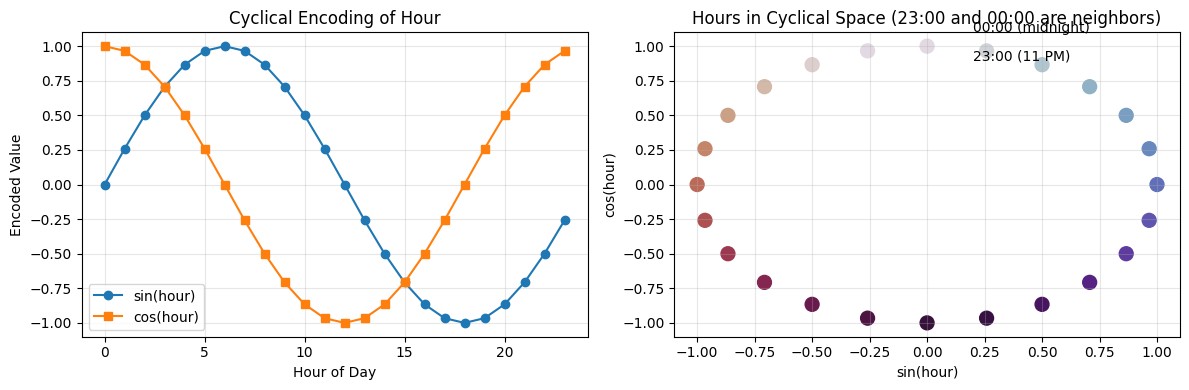

In [16]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Hour encoding
hours = np.arange(24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

# Plot sine and cosine
axes[0].plot(hours, hour_sin, label='sin(hour)', marker='o')
axes[0].plot(hours, hour_cos, label='cos(hour)', marker='s')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Encoded Value')
axes[0].set_title('Cyclical Encoding of Hour')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show hours in 2D space (as points on a circle)
axes[1].scatter(hour_sin, hour_cos, c=hours, cmap='twilight', s=100)
axes[1].set_xlabel('sin(hour)')
axes[1].set_ylabel('cos(hour)')
axes[1].set_title('Hours in Cyclical Space (23:00 and 00:00 are neighbors)')
axes[1].grid(True, alpha=0.3)

# Highlight midnight and 11 PM
axes[1].annotate('00:00 (midnight)', xy=(hour_sin[0], hour_cos[0]), xytext=(0.2, 1.1))
axes[1].annotate('23:00 (11 PM)', xy=(hour_sin[23], hour_cos[23]), xytext=(0.2, 0.9))

plt.tight_layout()
plt.show()

**Key Insight**: In the circular representation, hour 23 and hour 0 are right next to each other, which matches reality! This helps models understand that 11 PM and midnight are similar times.

## 6. Interaction Features

### Capturing Relationships Between Features

Sometimes the combination of two features is more informative than either feature alone. For example:
- **Age × Income**: Young high-earners behave differently than older high-earners
- **Weekend × Evening**: Weekend evenings are special (date night!)
- **Size × Weight**: Together they might indicate density

Let's create some interaction features:

In [17]:
# Create sample data for interactions
df_interact = pd.DataFrame({
    'feature1': np.random.randn(100),
    'feature2': np.random.randn(100),
    'feature3': np.random.randn(100),
    'age': np.random.uniform(18, 80, 100),
    'income': np.random.lognormal(10, 1, 100)
})

# Manual interaction features - when you know what relationships matter
df_interact['age_income_interaction'] = df_interact['age'] * df_interact['income']
df_interact['feature1_feature2'] = df_interact['feature1'] * df_interact['feature2']
df_interact['feature_sum'] = df_interact['feature1'] + df_interact['feature2'] + df_interact['feature3']
df_interact['feature_product'] = df_interact['feature1'] * df_interact['feature2'] * df_interact['feature3']

print("Manual interaction features:")
print(df_interact[['feature1', 'feature2', 'feature1_feature2', 'age_income_interaction']].head())

Manual interaction features:
   feature1  feature2  feature1_feature2  age_income_interaction
0 -0.811611  1.600904          -1.299310            5.145915e+05
1 -1.111804  0.936354          -1.041042            5.505686e+05
2  0.722057 -0.538773          -0.389025            1.151432e+06
3  1.296470 -0.885257          -1.147709            1.554654e+06
4 -0.872696 -0.725004           0.632709            1.013679e+06


### Systematic Interaction Creation with PolynomialFeatures

When you want to create ALL possible interactions systematically, scikit-learn's PolynomialFeatures is your friend:

In [18]:
# Using PolynomialFeatures for systematic interaction creation
from sklearn.preprocessing import PolynomialFeatures

# Select features for polynomial expansion
features_for_poly = df_interact[['feature1', 'feature2', 'feature3']].values

# Create polynomial features (degree=2 includes all pairs)
poly = PolynomialFeatures(
    degree=2,           # Include up to 2-way interactions
    include_bias=False  # Don't include a constant term
)
poly_features = poly.fit_transform(features_for_poly)

# Get feature names
poly_names = poly.get_feature_names_out(['feature1', 'feature2', 'feature3'])

# Create DataFrame with polynomial features
df_poly = pd.DataFrame(poly_features, columns=poly_names)

print(f"Original features: {features_for_poly.shape[1]}")
print(f"Polynomial features: {poly_features.shape[1]}")
print("\nPolynomial feature names:")
print(poly_names)
print("\nFirst few rows of polynomial features:")
print(df_poly.head())

Original features: 3
Polynomial features: 9

Polynomial feature names:
['feature1' 'feature2' 'feature3' 'feature1^2' 'feature1 feature2'
 'feature1 feature3' 'feature2^2' 'feature2 feature3' 'feature3^2']

First few rows of polynomial features:
   feature1  feature2  feature3  feature1^2  feature1 feature2  \
0 -0.811611  1.600904 -1.807891    0.658712          -1.299310   
1 -1.111804  0.936354  0.621783    1.236108          -1.041042   
2  0.722057 -0.538773 -1.610172    0.521367          -0.389025   
3  1.296470 -0.885257  1.295029    1.680834          -1.147709   
4 -0.872696 -0.725004  0.589294    0.761598           0.632709   

   feature1 feature3  feature2^2  feature2 feature3  feature3^2  
0           1.467304    2.562893          -2.894260    3.268471  
1          -0.691300    0.876759           0.582209    0.386614  
2          -1.162636    0.290277           0.867517    2.592653  
3           1.678966    0.783680          -1.146434    1.677100  
4          -0.514274    0.5

**Key Insight**: With just 3 original features, we created 9 polynomial features (3 original + 3 squared + 3 interactions). Be careful - this grows quickly with more features!

## 7. Text Feature Engineering

### Extracting Numbers from Words

Text data seems incompatible with machine learning (which needs numbers), but we can extract many numerical features from text:
- **Basic statistics**: length, word count, etc.
- **Pattern detection**: emails, URLs, phone numbers
- **Sentiment**: positive/negative emotion
- **Topics**: what the text is about

Let's create some sample text data:

In [19]:
# Create sample text data (customer reviews)
sample_texts = [
    "This product is amazing! I love it so much!!!!",
    "Terrible experience. Would not recommend.",
    "Good quality for the price. Fast shipping.",
    "The customer service was helpful. My issue was resolved quickly.",
    "Not what I expected based on the description. Disappointed.",
    "Excellent! Exceeded my expectations. Will buy again.",
    "Average product. Nothing special but does the job.",
    "URGENT: Please contact support at support@example.com or call 555-123-4567",
    "Visit our website at https://www.example.com for more deals!",
    "5 stars! Best purchase ever! Highly recommend to everyone!"
]

df_text = pd.DataFrame({'text': sample_texts})
print("Sample text data:")
for i, text in enumerate(df_text['text'][:3]):
    print(f"{i}: {text}")

Sample text data:
0: This product is amazing! I love it so much!!!!
1: Terrible experience. Would not recommend.
2: Good quality for the price. Fast shipping.


### Basic Text Statistics

Let's start with simple counts and statistics:

In [20]:
# Basic text statistics
df_text['char_count'] = df_text['text'].str.len()
df_text['word_count'] = df_text['text'].str.split().str.len()
df_text['sentence_count'] = df_text['text'].str.count('[.!?]') + 1
df_text['avg_word_length'] = df_text['char_count'] / df_text['word_count']

# Capital letters might indicate SHOUTING or emphasis
df_text['uppercase_ratio'] = df_text['text'].str.findall(r'[A-Z]').str.len() / df_text['char_count']

print("Basic text features:")
print(df_text[['text', 'word_count', 'avg_word_length', 'uppercase_ratio']].head())

Basic text features:
                                                text  word_count  \
0     This product is amazing! I love it so much!!!!           9   
1          Terrible experience. Would not recommend.           5   
2         Good quality for the price. Fast shipping.           7   
3  The customer service was helpful. My issue was...          10   
4  Not what I expected based on the description. ...           9   

   avg_word_length  uppercase_ratio  
0         5.111111         0.043478  
1         8.200000         0.048780  
2         6.000000         0.047619  
3         6.400000         0.031250  
4         6.555556         0.050847  


### Pattern Detection with Regular Expressions

Regular expressions (regex) help us find specific patterns in text:

In [21]:
# Pattern detection using regex
df_text['has_phone'] = df_text['text'].str.contains(r'\d{3}[-.]?\d{3}[-.]?\d{4}', regex=True).astype(int)
df_text['has_email'] = df_text['text'].str.contains(r'\S+@\S+', regex=True).astype(int)
df_text['has_url'] = df_text['text'].str.contains(r'http[s]?://', regex=True).astype(int)

# Emotional indicators
df_text['exclamation_count'] = df_text['text'].str.count('!')
df_text['question_count'] = df_text['text'].str.count('\?')

print("Pattern detection features:")
print(df_text[['text', 'has_email', 'has_url', 'exclamation_count']].head())

Pattern detection features:
                                                text  has_email  has_url  \
0     This product is amazing! I love it so much!!!!          0        0   
1          Terrible experience. Would not recommend.          0        0   
2         Good quality for the price. Fast shipping.          0        0   
3  The customer service was helpful. My issue was...          0        0   
4  Not what I expected based on the description. ...          0        0   

   exclamation_count  
0                  5  
1                  0  
2                  0  
3                  0  
4                  0  


<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:8: SyntaxWarning: invalid escape sequence '\?'
/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_87968/2579993006.py:8: SyntaxWarning: invalid escape sequence '\?'
  df_text['question_count'] = df_text['text'].str.count('\?')


### Sentiment Analysis

Sentiment analysis determines if text is positive, negative, or neutral:

In [22]:
# Sentiment analysis using TextBlob
try:
    from textblob import TextBlob
    
    # Calculate sentiment (-1 = very negative, +1 = very positive)
    df_text['sentiment'] = df_text['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Subjectivity (0 = objective fact, 1 = subjective opinion)
    df_text['subjectivity'] = df_text['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Categorize sentiment
    df_text['sentiment_category'] = pd.cut(
        df_text['sentiment'], 
        bins=[-1, -0.1, 0.1, 1], 
        labels=['negative', 'neutral', 'positive']
    )
    
    print("Sentiment features:")
    print(df_text[['text', 'sentiment', 'sentiment_category']].head())
except ImportError:
    print("TextBlob not installed. Install with: pip install textblob")

Sentiment features:
                                                text  sentiment  \
0     This product is amazing! I love it so much!!!!   0.579427   
1          Terrible experience. Would not recommend.  -1.000000   
2         Good quality for the price. Fast shipping.   0.450000   
3  The customer service was helpful. My issue was...   0.333333   
4  Not what I expected based on the description. ...  -0.425000   

  sentiment_category  
0           positive  
1                NaN  
2           positive  
3           positive  
4           negative  


### Advanced: TF-IDF for Text Classification

TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical features based on word importance:

In [23]:
# TF-IDF features for text classification
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF features
tfidf = TfidfVectorizer(
    max_features=20,        # Keep only top 20 features
    stop_words='english',   # Remove common words like 'the', 'is'
    ngram_range=(1, 2)      # Include single words and word pairs
)

tfidf_features = tfidf.fit_transform(df_text['text'])
tfidf_feature_names = tfidf.get_feature_names_out()

# Convert to DataFrame for visualization
tfidf_df = pd.DataFrame(
    tfidf_features.toarray(),
    columns=[f'tfidf_{name}' for name in tfidf_feature_names]
)

print("TF-IDF features shape:", tfidf_df.shape)
print("\nTop TF-IDF features (important words/phrases):")
print(tfidf_feature_names[:10])

TF-IDF features shape: (10, 20)

Top TF-IDF features (important words/phrases):
['com' 'example' 'example com' 'highly recommend' 'https' 'https www'
 'issue' 'issue resolved' 'job' 'price']


**Key Insight**: TF-IDF automatically identifies the most important and distinctive words in your text, creating features that can be used for classification or clustering.

## Practice Exercises

Now it's your turn! Try these exercises to reinforce your learning:

### Exercise 1: Create Your Own Features
Using any of the dataframes created above, engineer 5 new features that might be predictive for a business problem of your choice.

In [24]:
# Your code here:
# Example: Predict customer churn
# Create features like:
# - days_since_last_purchase
# - purchase_frequency_trend
# - complaint_ratio
# etc.


### Exercise 2: Build a Feature Engineering Function
Create a reusable function that takes a datetime column and automatically generates useful temporal features.

In [25]:
def extract_temporal_features(df, date_column):
    """
    Extract comprehensive temporal features from a datetime column.
    
    Parameters:
    df: DataFrame
    date_column: name of the datetime column
    
    Returns:
    DataFrame with new temporal features
    """
    # Your code here:
    # Extract: year, month, day, hour, dayofweek
    # Create: is_weekend, is_holiday, is_month_end
    # Add: cyclical encoding for hour and month
    pass


### Exercise 3: Text Feature Pipeline
Create a function that takes a text column and extracts at least 10 different features.

In [26]:
def extract_text_features(text_series):
    """
    Extract multiple features from text data.
    
    Parameters:
    text_series: Pandas Series containing text
    
    Returns:
    DataFrame with text features
    """
    # Your code here:
    # Calculate: length, word count, sentiment
    # Detect: URLs, emails, questions
    # Extract: TF-IDF features
    pass


## Key Takeaways

### Remember These Critical Points:

1. **Feature engineering often matters more than model selection** - A simple model with great features beats a complex model with poor features

2. **Start simple, then iterate** - Basic ratios and transformations often provide the most value

3. **Domain knowledge is gold** - Understanding your business/field helps you create meaningful features

4. **Always handle edge cases** - Add 1 to denominators, use log1p instead of log, check for missing values

5. **Validate your features** - Not every engineered feature will be useful; test them!

6. **Consider production constraints** - Some features are expensive to compute in real-time

7. **Document your logic** - Your future self (and teammates) need to understand why you created each feature

8. **Watch for data leakage** - Never use information from the future or information that won't be available at prediction time

### Next Steps:
- Practice with your own datasets
- Experiment with different transformations
- Learn more about domain-specific feature engineering
- Study feature selection techniques to identify which features actually help

Remember: Feature engineering is both an art and a science. The more you practice, the better your intuition becomes!